# TVAR PINN with PyTorch
This notebook demonstrates how to use a modern automatic‑differentiation framework (PyTorch)
to learn time‑varying autoregressive (TVAR) coefficients for a simulated signal with constant
sliding‑window power.  The goal is to illustrate how automatic differentiation and an optimiser
such as Adam can replace the manual gradient calculations used previously.


## Background
TVAR models describe signals whose autoregressive coefficients change over time.  Estimating these coefficients
is challenging, particularly when only weak constraints such as constant sliding‑window power are available;
multiple coefficient trajectories can reproduce the same signal【988150528581547†L918-L933】.  We use a physics‑informed neural network
(PINN) to embed prior knowledge into the loss function: an autoregressive residual term, an energy penalty
to enforce constant power, and a smoothness regulariser.  Unlike the earlier implementation, the neural network
and its gradients are implemented using PyTorch, which handles automatic differentiation【672647501557241†L152-L160】.


## Signal Simulation (NumPy)
First, we simulate a one‑dimensional time series governed by a TVAR(2) process.  The underlying AR coefficients
vary slowly and produce low‑frequency oscillatory dynamics reminiscent of local field potentials (LFPs).
The signal is scaled to maintain constant sliding‑window power.

Run the following code cell to generate the simulated signal and display its sliding‑window power.  Adjust the
`freq1`, `freq2`, `P0`, and `W` parameters to modify the underlying dynamics and the window size used for the power constraint.


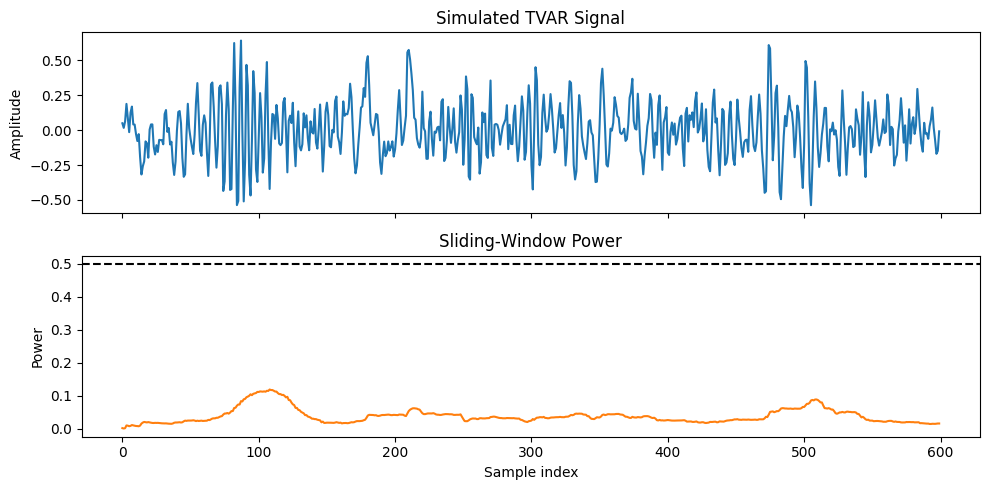

In [7]:

import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
N = 600  # length of the time series
p = 2    # autoregressive order
W = 40   # window length for constant power
P0 = 0.5 # target sliding‑window power
sigma_noise = 0.1

# Frequencies for slowly varying coefficients
freq1 = 1/150
freq2 = 1/200

# Functions generating true AR coefficients
a1_func = lambda t: 0.6 + 0.35 * np.sin(2 * np.pi * freq1 * t)
a2_func = lambda t: -0.5 + 0.25 * np.cos(2 * np.pi * freq2 * t)

# Generate coefficients over time
coeffs_true = np.zeros((N, p))
for t in range(N):
    coeffs_true[t, 0] = a1_func(t)
    coeffs_true[t, 1] = a2_func(t)

# Simulate the TVAR signal and enforce constant window power
x = np.zeros(N)
np.random.seed(42)
for i in range(N):
    # base white noise
    val = np.random.normal(scale=sigma_noise)
    # autoregressive component
    for k in range(1, p+1):
        if i >= k:
            val += coeffs_true[i, k-1] * x[i-k]
    x[i] = val
    # enforce power constraint after W samples
    if i >= W-1:
        window = x[i-W+1:i+1]
        current_power = np.mean(window**2)
        s = np.sqrt(P0 / current_power) if current_power > 0 else 1.0
        # clip scaling factor to avoid extreme values
        s = np.clip(s, 0.8, 1.2)
        x[i] *= s

# Compute sliding‑window power for plotting
power = np.zeros(N)
for i in range(N):
    start = max(0, i-W+1)
    window = x[start:i+1]
    power[i] = np.mean(window**2)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax[0].plot(x)
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Simulated TVAR Signal')
ax[1].plot(power, color='tab:orange')
ax[1].axhline(P0, color='k', linestyle='--')
ax[1].set_xlabel('Sample index')
ax[1].set_ylabel('Power')
ax[1].set_title('Sliding‑Window Power')
plt.tight_layout()


## PINN Definition and Training with PyTorch
We now define a simple feed‑forward neural network using PyTorch.  The network takes a normalised time coordinate
`t_norm` as input and outputs two values corresponding to the AR coefficients at that time.  A scaling factor
`scale_coeff` keeps the raw network outputs within a range that tends to yield stable AR processes.

The loss function consists of three terms:
1. **Autoregressive residual** between the observed signal and the one‑step prediction using the predicted coefficients.
2. **Energy penalty** encouraging the sliding‑window power of the predicted signal to match the target `P0`.
3. **Smoothness penalty** on changes in the predicted coefficients over time.

We train the network using the Adam optimiser.  Note that PyTorch must be installed to run this cell; the code
is provided here as a template for execution on systems with PyTorch available.


Epoch 100/1000, loss=0.041237, ar=0.018625, energy=0.226123, smooth=0.000002
Epoch 200/1000, loss=0.037833, ar=0.015548, energy=0.222846, smooth=0.000076
Epoch 300/1000, loss=0.036372, ar=0.014253, energy=0.221178, smooth=0.000143
Epoch 400/1000, loss=0.036160, ar=0.014079, energy=0.220789, smooth=0.000195
Epoch 500/1000, loss=0.035938, ar=0.013889, energy=0.220469, smooth=0.000235
Epoch 600/1000, loss=0.035450, ar=0.013432, energy=0.220154, smooth=0.000305
Epoch 700/1000, loss=0.034854, ar=0.012883, energy=0.219667, smooth=0.000389
Epoch 800/1000, loss=0.034690, ar=0.012753, energy=0.219326, smooth=0.000442
Epoch 900/1000, loss=0.034627, ar=0.012702, energy=0.219203, smooth=0.000473
Epoch 1000/1000, loss=0.034577, ar=0.012658, energy=0.219143, smooth=0.000499


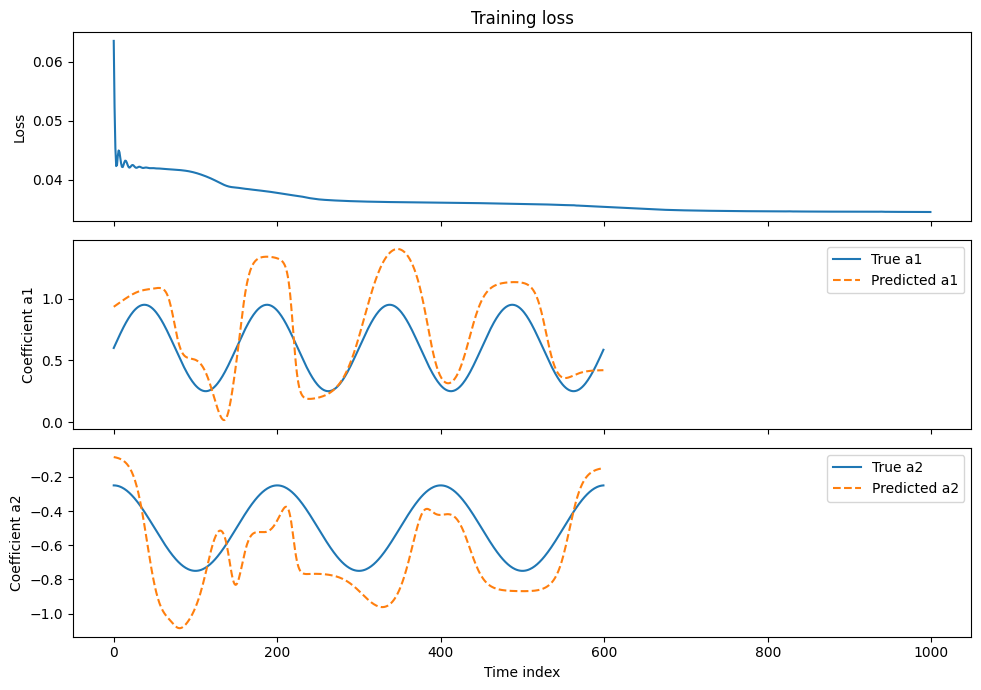

In [8]:

# PyTorch implementation
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Ensure that a GPU is used if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert numpy arrays to torch tensors
x_torch = torch.tensor(x, dtype=torch.float32, device=device)
coeffs_true_torch = torch.tensor(coeffs_true, dtype=torch.float32, device=device)

# Create normalized time input
t_norm = torch.linspace(0.0, 1.0, N, dtype=torch.float32, device=device).view(-1, 1)

class TVARPINN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=40, output_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.activation = torch.tanh
    def forward(self, t):
        x = self.activation(self.fc1(t))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

# Hyperparameters
hidden_dim = 40
scale_coeff = 0.5
lambda_energy = 0.1
lambda_smooth = 0.01
learning_rate = 0.01
n_epochs = 1000

# Instantiate model and optimizer
model = TVARPINN(input_dim=1, hidden_dim=hidden_dim, output_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
loss_history = []
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Predict coefficients for all time points, then select those for indices >= p
    coeff_pred = model(t_norm) * scale_coeff
    coeff_pred_use = coeff_pred[p:]
    
    # Compute one‑step predictions using the predicted coefficients
    M = N - p
    x_hat = []
    for i in range(p, N):
        past_vals = torch.tensor([x_torch[i-1], x_torch[i-2]], dtype=torch.float32, device=device)
        coeffs = coeff_pred_use[i - p]
        x_hat.append((coeffs * past_vals).sum())
    x_hat = torch.stack(x_hat)
    
    # Autoregressive residual loss
    y_true = x_torch[p:]
    loss_ar = torch.mean((y_true - x_hat) ** 2)
    
    # Sliding‑window power of the predicted signal
    window_powers = []
    for j in range(M):
        start = max(0, j - W + 1)
        window = x_hat[start:j+1]
        power_hat = torch.mean(window**2)
        window_powers.append(power_hat)
    window_powers = torch.stack(window_powers)
    loss_energy = torch.mean((window_powers - P0) ** 2)
    
    # Smoothness penalty on coefficient differences
    diffs = coeff_pred_use[1:] - coeff_pred_use[:-1]
    loss_smooth = torch.mean(torch.sum(diffs**2, dim=1))
    
    # Total loss
    loss = loss_ar + lambda_energy * loss_energy + lambda_smooth * loss_smooth
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if (epoch+1) % (n_epochs // 10) == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, loss={loss.item():.6f}, ar={loss_ar.item():.6f}, energy={loss_energy.item():.6f}, smooth={loss_smooth.item():.6f}")

# After training, evaluate coefficients over all time
model.eval()
with torch.no_grad():
    coeff_pred_full = model(t_norm) * scale_coeff
coeff_pred_full = coeff_pred_full.cpu().numpy()

# Plot results
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
axes[0].plot(loss_history)
axes[0].set_ylabel('Loss')
axes[0].set_title('Training loss')

axes[1].plot(coeffs_true[:, 0], label='True a1')
axes[1].plot(coeff_pred_full[:, 0], label='Predicted a1', linestyle='--')
axes[1].set_ylabel('Coefficient a1')
axes[1].legend()

axes[2].plot(coeffs_true[:, 1], label='True a2')
axes[2].plot(coeff_pred_full[:, 1], label='Predicted a2', linestyle='--')
axes[2].set_ylabel('Coefficient a2')
axes[2].set_xlabel('Time index')
axes[2].legend()

plt.tight_layout()


## Discussion
In this PyTorch implementation, automatic differentiation handles backpropagation through the network and the
complex loss function, simplifying the coding effort compared to manual gradient calculations.
The training loop may still take time to converge, and the estimates for the coefficients may not perfectly match
the true trajectories due to identifiability issues and the weak power constraint.  You can experiment with
different network sizes, loss weights (`lambda_energy`, `lambda_smooth`), learning rates, and epoch counts
to improve performance.  Additionally, consider enforcing stability constraints on the AR coefficients or adding
other physical constraints (e.g., spectral envelopes) to regularise the problem.
